<a href="https://colab.research.google.com/github/Ahmedtambal/API/blob/master/11_An_application_of_a_classification_problem_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An application of a classification problem - Fraud Detection
Electricity and Gas Consumption Challenge
by : Ahmed Tambal (Sudan)

huge appreciation for Zindi for all It's efforts to bring African Data Scientists closer

Index :

importing libraries

*   importing libraries
*   basic EDA
*   feature engeneering
*   modelling and fitting
*   make some prediction
*   submission file


In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMClassifier
import time

seed=47
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [ ]:
#Getting the data from Google Drive

train_invoice = "/content/drive/MyDrive/Fraud Detection/invoice_train.csv"
train_client = "/content/drive/MyDrive/Fraud Detection/client_train.csv"
test_invoice = "/content/drive/MyDrive/Fraud Detection/invoice_test.csv"
test_client = "/content/drive/MyDrive/Fraud Detection/client_test.csv"

In [ ]:
#Reading The data using pd.read_csv

invoice_train = pd.read_csv("/content/drive/MyDrive/Fraud Detection/invoice_train.csv",low_memory=False)
invoice_test = pd.read_csv("/content/drive/MyDrive/Fraud Detection/invoice_test.csv",low_memory=False)
client_train = pd.read_csv("/content/drive/MyDrive/Fraud Detection/client_train.csv",low_memory=False)
client_test = pd.read_csv("/content/drive/MyDrive/Fraud Detection/client_test.csv",low_memory=False)
SampleSubmission = pd.read_csv("/content/drive/MyDrive/Fraud Detection/SampleSubmission.csv",low_memory=False)

In [ ]:
# first 5 rows
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [ ]:
# first 5 rows
invoice_train.head()


,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [ ]:
# some info about the data

client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [ ]:
# some info about the data

invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [ ]:
# checking to see if there's empty values

invoice_train.isna().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [ ]:
# checking to see if there's empty values

client_train.isna().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [ ]:
# some statistics info about the data

invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [ ]:
# some statistics info about the data

client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


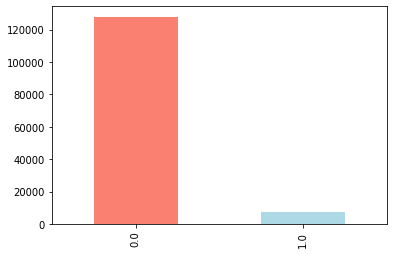

In [ ]:
# comparison between target an id column

client_train.target.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

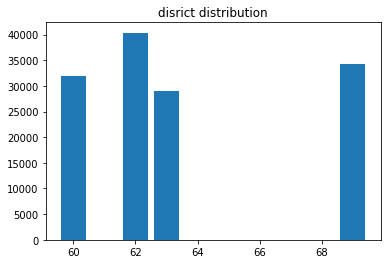

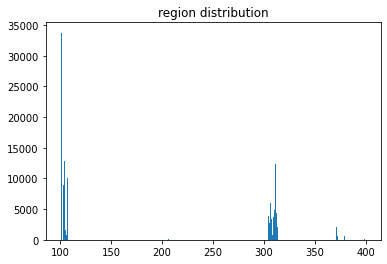

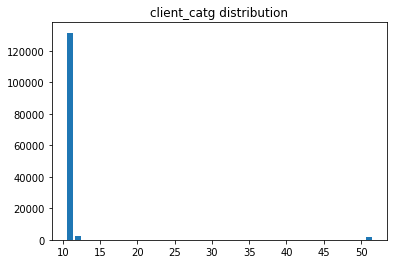

In [ ]:
# comparison between disrict , region and client_catg vs id

for col in ['disrict','region','client_catg']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

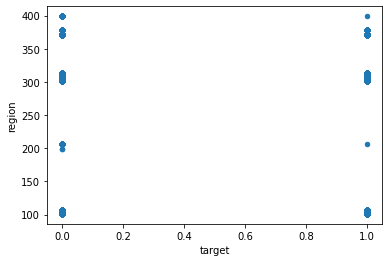

In [ ]:
## comparison between region vs target

client_train[['region' , 'target']].plot(kind ='scatter' , x ='target' , y = 'region' )

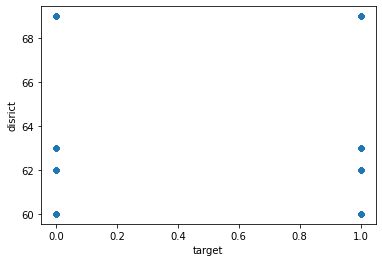

In [ ]:
## comparison between disrict vs target

client_train[['disrict' , 'target']].plot(kind ='scatter' , x ='target' , y = 'disrict' )

In [ ]:
# unique values in our invoice data

print('Number of unique values in invoice_train:')
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

Number of unique values in invoice_train:
client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [ ]:
# unique values in our invoice test data

print('Number of unique values in invoice_test:')
for col in invoice_test.columns:
    print(f"{col} - {invoice_test[col].nunique()}")

Number of unique values in invoice_test:
client_id - 58069
invoice_date - 6934
tarif_type - 16
counter_number - 91966
counter_statue - 6
counter_code - 39
reading_remarque - 4
counter_coefficient - 7
consommation_level_1 - 6546
consommation_level_2 - 9700
consommation_level_3 - 1862
consommation_level_4 - 8838
old_index - 116512
new_index - 118365
months_number - 914
counter_type - 2


notes from the above comparison :

*   I think there's something wrong with this column's values [counter_statue ]
let's see

In [ ]:
print(invoice_train['counter_statue'].unique())

['0' '1' '5' '4' '3' '2' '769' 'A' '618' '269375' '46' '420']


In [ ]:
print(invoice_test['counter_statue'].unique())

[0 1 5 4 3 2]


this coulmn above has mislabled data


In [ ]:
print(invoice_train['counter_type'].unique())

['ELEC' 'GAZ']


# **## Preforming Feature engineering ##**

from the analysis above we need to prefrom the below ops :

converting ELEC and Gas to numric values (0 , 1)

In [ ]:
# we need to lable encoding the counter_type column to be 0,1

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'counter_type'.
invoice_train['counter_type']= label_encoder.fit_transform(invoice_train['counter_type'])

invoice_train['counter_type'].unique()

array([0, 1])

In [ ]:
# check the counter_type column

print(invoice_train['counter_type'].unique())

[0 1]


In [ ]:
# now for the test data

invoice_test['counter_type']= label_encoder.fit_transform(invoice_test['counter_type'])

invoice_test['counter_type'].unique()

array([0, 1])


function to do the next in client data:


*   convert creation_date to data_time object

*   convert columns (client_catg , disrict and region) to a type category

*   from the analysis above in EDA PLT figuers regarding the region plot it appears that all the user id is between these region(100 , 200 , 300 ) so we divded the  [region] values into 3 groups

*   finally create TSC to know when the account been created





In [ ]:
def client_feature_eng(client):

    client['creation_date'] = pd.to_datetime(client['creation_date'])

    client['client_catg'] = client['client_catg'].astype('category')
    client['disrict'] = client['disrict'].astype('category')
    client['region'] = client['region'].astype('category')

    client['region_group'] = client['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)

    client['TSC'] = (2021 - client['creation_date'].dt.year)*12 - client['creation_date'].dt.month



    return client

## And for the Invoice data :



*   convert creation_date to data_time object and made year and month and day columns

*   fix Column counter_statue mislabled values
*   made new column called delta_index which is made some improvment in the score

In [ ]:
def invoice_feature_eng(invoice):

      invoice['invoice_date'] = pd.to_datetime(invoice['invoice_date'], dayfirst=True)
      invoice['invoice_month'] = invoice['invoice_date'].dt.day
      invoice['invoice_month'] = invoice['invoice_date'].dt.week
      invoice['invoice_month'] = invoice['invoice_date'].dt.month
      invoice['invoice_year'] = invoice['invoice_date'].dt.year

      invoice['counter_statue'] = invoice['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5})

      invoice['delta_index'] = invoice['new_index'] - invoice['old_index']

      invoice['is_weekday'] = ((pd.DatetimeIndex(invoice.invoice_date).dayofweek) // 5 == 1).astype(float)


      return invoice

In [ ]:
# apply changes to both train and test
client_trainnew = client_feature_eng(client_train)
client_testnew = client_feature_eng(client_test)

invoice_trainnew = invoice_feature_eng(invoice_train)
invoice_testnew = invoice_feature_eng(invoice_test)

now for the below  

* delta time = amount of time between the invoices


* assigned some  aggregation features (max/mean/nunique/min/std) for contnious column except id column


* invoice_per_cooperation = number of transactions for some amount of time


In [ ]:
def agg_feature(invoice, client_df, agg_stat):

    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['median','nunique','mean','std','min','max'])

    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')

    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')

    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')

    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['TSC']

    return full_df

In [ ]:

agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

train_df1 = agg_feature(invoice_trainnew, client_trainnew, agg_stat_columns)
test_df1 = agg_feature(invoice_testnew, client_testnew, agg_stat_columns)

statistical 'max_mean' and 'range' features which improved score

In [ ]:
def new_features(df):

    for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']

    return df

In [ ]:
train_df2 = new_features(train_df1)
test_df2 = new_features(test_df1)

In [ ]:
# droping id and create date columns
def drop(df):
    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

In [ ]:
train_df = drop(train_df2)
test_df = drop(test_df2)

# Modeling

In [ ]:
y = train_df['target']
X = train_df.drop('target',axis=1)

feature_name = X.columns.tolist()

In [ ]:
# drop additional columns , too many features
drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean']
#assigning X , Y
X = X.drop(drop_col, axis=1)
test_df = test_df.drop(drop_col, axis=1)




*   using LightGBM
*   optuna for hyperparameters tuning
*   Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API. Thanks to our define-by-run API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.


*   performed with respect to StratifiedKFold cross validation on 5 folds
*   parameters were tuned but didn't achive the best score, but after
manul tuning on the hyperparameter tuning results and adding of another parameters it did score higher



In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna
from optuna import Trial
import gc
import optuna
from sklearn.model_selection import train_test_split
import lightgbm as lgb

category_cols = ['disrict', 'client_catg', 'region']

def objective(trial:Trial):

    gc.collect()
    models=[]
    validScore=0

    model,log = fitLGBM(trial,X,y)

    models.append(model)
    gc.collect()
    validScore+=log
    validScore/=len(models)

    return validScore

In [ ]:
def fitLGBM(trial,X, y):

    params={
      'n_estimators':trial.suggest_int('n_estimators', 0, 1000),
      'num_leaves':trial.suggest_int('num_leaves', 2, 512),
      'max_depth':trial.suggest_int('max_depth', 2, 128),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.15),
      'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.001, 0.1),
      'feature_fraction':trial.suggest_uniform('feature_fraction',0.1, 1.0),
      'bagging_freq':trial.suggest_int('bagging_freq',0.1,10),
      'verbosity': -1,
      'random_state':seed
            }

    # StratifiedKFold object with 5 splits, shuffle=True, random_state=seed.
    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = LGBMClassifier(**params)

    res=[]
    for i, (tdx, vdx) in enumerate(stkfold.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        preds = model.predict_proba(X_valid)
        res.append(roc_auc_score(y_valid, preds[:,1]))

    err = np.mean(res)

    return model, err

In [ ]:
model = LGBMClassifier(random_state=seed, n_estimators=861,num_leaves=136, max_depth=119,
                       learning_rate=0.01034258141362138, min_split_gain=0.001658092505404705,
                       feature_fraction=0.5447241621043165, bagging_freq=0)

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def calc(X, y, model, cv):
    res=[]
    local_probs=pd.DataFrame()
    probs = pd.DataFrame()

    for i, (tdx, vdx) in enumerate(cv.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)

        preds = model.predict_proba(X_valid)
        oof_predict = model.predict_proba(test_df)
        local_probs['fold_%i'%i] = oof_predict[:,1]
        res.append(roc_auc_score(y_valid, preds[:,1]))

    print('ROC AUC:', round(np.mean(res), 6))
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']

    return probs

In [ ]:
%%time
probs = calc(X, y, model, stkfold)

ROC AUC: 0.896364
CPU times: user 10min 30s, sys: 4.31 s, total: 10min 34s
Wall time: 5min 29s


## submission

In [ ]:
submission = pd.DataFrame({
        "client_id": SampleSubmission["client_id"],
        "target": probs['target']
    })
submission.to_csv(r'/content/drive/MyDrive/sm32.csv', index = False)